In [6]:
from skimage import io,filters, morphology, measure, draw,exposure
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import trackpy as tp
import pandas as pd
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
from skimage.filters import threshold_otsu, threshold_multiotsu
import seaborn as sns
from tqdm import tqdm

In [7]:
PATH = "<PATH/TO/DIR>/WAVE/Fig2_FigS2CD_Hem1KO/"

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
def f_linear(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

In [10]:
def seg_cells(image, threshold, sigma,min_size, max_size, plot = True):
    """
    Segment out regions with a given fluorescence threshold in a cell
 
    Parameters
    ----------
    image : 2D array
        Raw tif image (single frame).
    threshold: float
        threshold used for segmentation
    sigma: float
        Standard deviation for Gaussian kernel.The larger the value, the smoothier the gaussian fitting.
    min_size: float
        minimum size of the segmented region
    max_size: float
        maximum size of the segmented region
    plot: bool
        whether or not plot the segmentation image
    
    Returns
    -------
    region_properties: list of RegionProperties
        Each item describes one labeled region with the corresponding attributes. 
    label_mask_clean:2D array 
        Segmentations based on fluorescent intensities of the image. 
        Each integer corresponds to a unique segmentation and 0 is the background.
        
    """
    smooth = filters.gaussian(image,sigma,preserve_range=True)
    cell_mask = smooth > threshold
    label_mask = measure.label(cell_mask)
    region_properties = measure.regionprops(label_mask)  
    label_mask_clean = label_mask.copy()
    for r in region_properties:
        if r.area <= min_size or r.area >= max_size:
            label_mask_clean[label_mask_clean == r.label] = 0
    if plot:
        plt.figure(figsize = (10,10))
        plt.imshow(image)
        plt.contour(label_mask_clean,colors = 'red',linewidths = 0.7)

    region_properties = measure.regionprops(label_mask_clean,intensity_image=image)
    return region_properties,label_mask_clean

# Quantification of Hem1-eGFP

In [11]:
name = 'example_images/250307_Hem1-eGFP_WAVE2_IF_1-1_21.tif'
image = io.imread(PATH + name)

In [12]:
image.shape

(2, 1024, 1024)

In [13]:
WAVE2 = image[0]
Hem1 = image[1]

1205.061624912473


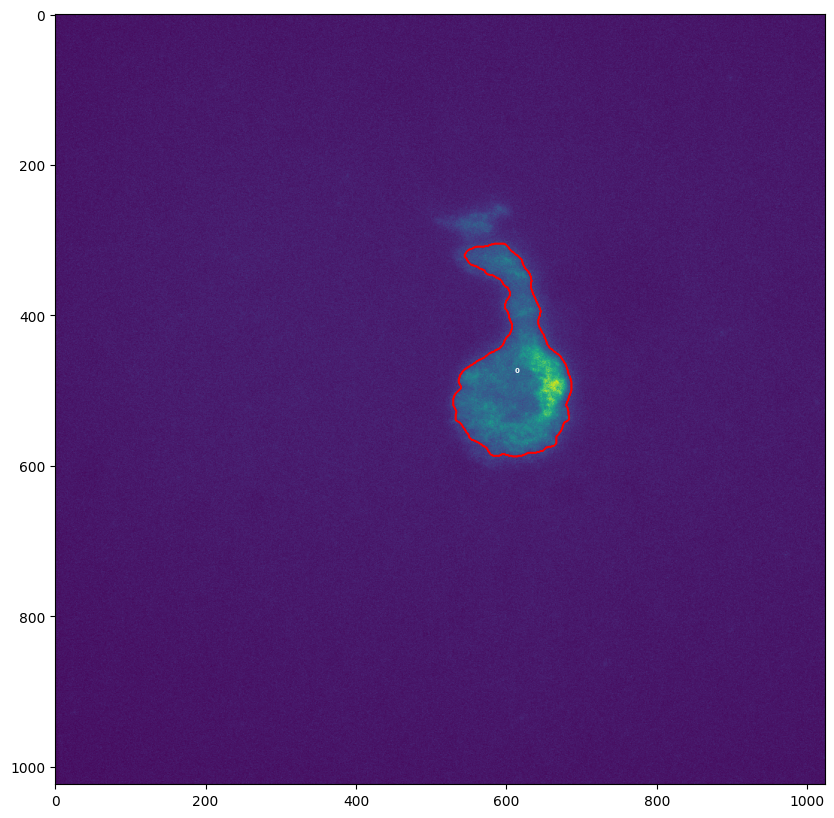

In [14]:
thres = threshold_otsu(Hem1)
# print(thres)
features = pd.DataFrame()

prop,label_mask_clean = seg_cells(Hem1,thres,3,7000,1200000,True)
background = np.sum((label_mask_clean==0)*Hem1)/np.count_nonzero((label_mask_clean==0))
print(background)
for j in range(len(prop)): 
    y_center, x_center = prop[j].centroid # note that image coordinates are often given as (y, x) rather than (x, y)
    plt.text(x_center, y_center, str(j), fontweight = 'bold', color = 'white',size = 5)

    features = features.append([{'cell':name,'label':prop[j].label,'x': prop[j].centroid[0],
                             'y': prop[j].centroid[1],'area':prop[j].area,
                             'Hem1_intensity':prop[j].intensity_mean,
                             'background':background,
                             'final_intensity':prop[j].intensity_mean - background}])


In [15]:
features

,cell,label,x,y,area,Hem1_intensity,background,final_intensity
0,example_images/250307_Hem1-eGFP_WAVE2_IF_1-1_2...,3,475.352705,610.285081,24607,3672.334498,1205.061625,2467.272873


In [16]:
region_properties = measure.regionprops(label_mask_clean,intensity_image=WAVE2)
background = np.sum((label_mask_clean==0)*WAVE2)/np.count_nonzero((label_mask_clean==0))
WAVE2_features = pd.DataFrame()
for j in range(len(region_properties)):
    WAVE2_features = WAVE2_features.append([{'WAVE2_area':region_properties[j].area,
                                           'WAVE2_intensity':region_properties[j].intensity_mean,
                                           'WAVE2_background':background,
                                           'WAVE2_final_intensity':region_properties[j].intensity_mean - background}])
# print(WAVE2_features)
features['WAVE2_area'] =WAVE2_features['WAVE2_area'] 
features['WAVE2_intensity'] =WAVE2_features['WAVE2_intensity'] 
features['WAVE2_background'] =WAVE2_features['WAVE2_background'] 
features['WAVE2_final_intensity'] =WAVE2_features['WAVE2_final_intensity'] 

In [17]:
features

,cell,label,x,y,area,Hem1_intensity,background,final_intensity,WAVE2_area,WAVE2_intensity,WAVE2_background,WAVE2_final_intensity
0,example_images/250307_Hem1-eGFP_WAVE2_IF_1-1_2...,3,475.352705,610.285081,24607,3672.334498,1205.061625,2467.272873,24607,3410.416589,998.50324,2411.913349


In [19]:
result = pd.DataFrame()
result = result.append(features)

# Generate plot

In [20]:
result = pd.read_csv(PATH +'csv_data/IF_quantification.csv',index_col = 0)

In [21]:
popt = curve_fit(f_linear,result.final_intensity,result.WAVE2_final_intensity)[0]

In [22]:
stats.pearsonr(result.final_intensity,result.WAVE2_final_intensity)

PearsonRResult(statistic=0.7513566880573652, pvalue=1.5028740505967506e-15)

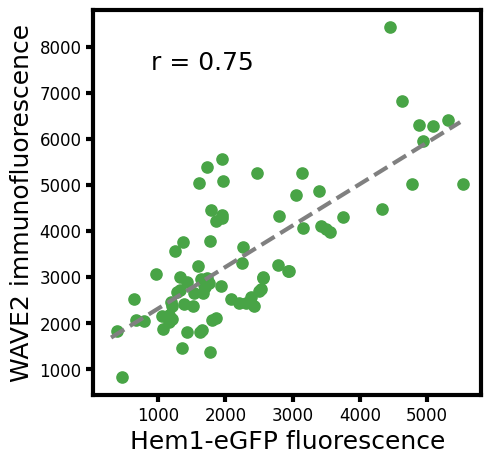

In [24]:
fig,ax  = plt.subplots(figsize = (5,5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3,size = 5)

plt.scatter(result.final_intensity,result.WAVE2_final_intensity,s = 65,c= '#48a446')
xn = np.arange(300,5500,30)
plt.plot(xn,f_linear(xn,popt[0],popt[1]),linestyle = '--',color = 'grey',lw = 3)
plt.ylabel('WAVE2 immunofluorescence',size = 18)
plt.xlabel('Hem1-eGFP fluorescence',size = 18)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.text(900,7500,'r = 0.75',size = 18)
plt.savefig(PATH +'result_figures/FigureS2C_WAVE2_IF_quantification.png',bbox_inches= 'tight',dpi = 300)